In [5]:
import geopandas as gpd
import mapclassify
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load data
gdf = gpd.read_file("C:/Users/Isabe/College/4th year/DS 3001/voting final/project_voting/va_admin_bndry/VirginiaCounty_ClippedToShoreline.shx") # Load Virginia shapefile for maps
vdf = pd.read_csv('C:/Users/Isabe/College/4th year/DS 3001/voting final/project_voting/data/voting_VA.csv') # Load historical voting data
cdf = pd.read_csv('C:/Users/Isabe/College/4th year/DS 3001/voting final/project_voting/data/county_adjacencies.csv') # Load county adjacency data and population data

# Merge shapefile data and county adjacency data:
gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS']) 
dfplotting = gdf.merge(cdf,left_on='FIPS_left',right_on='FIPS')  # merge county population and adjacency data into df
del gdf, cdf

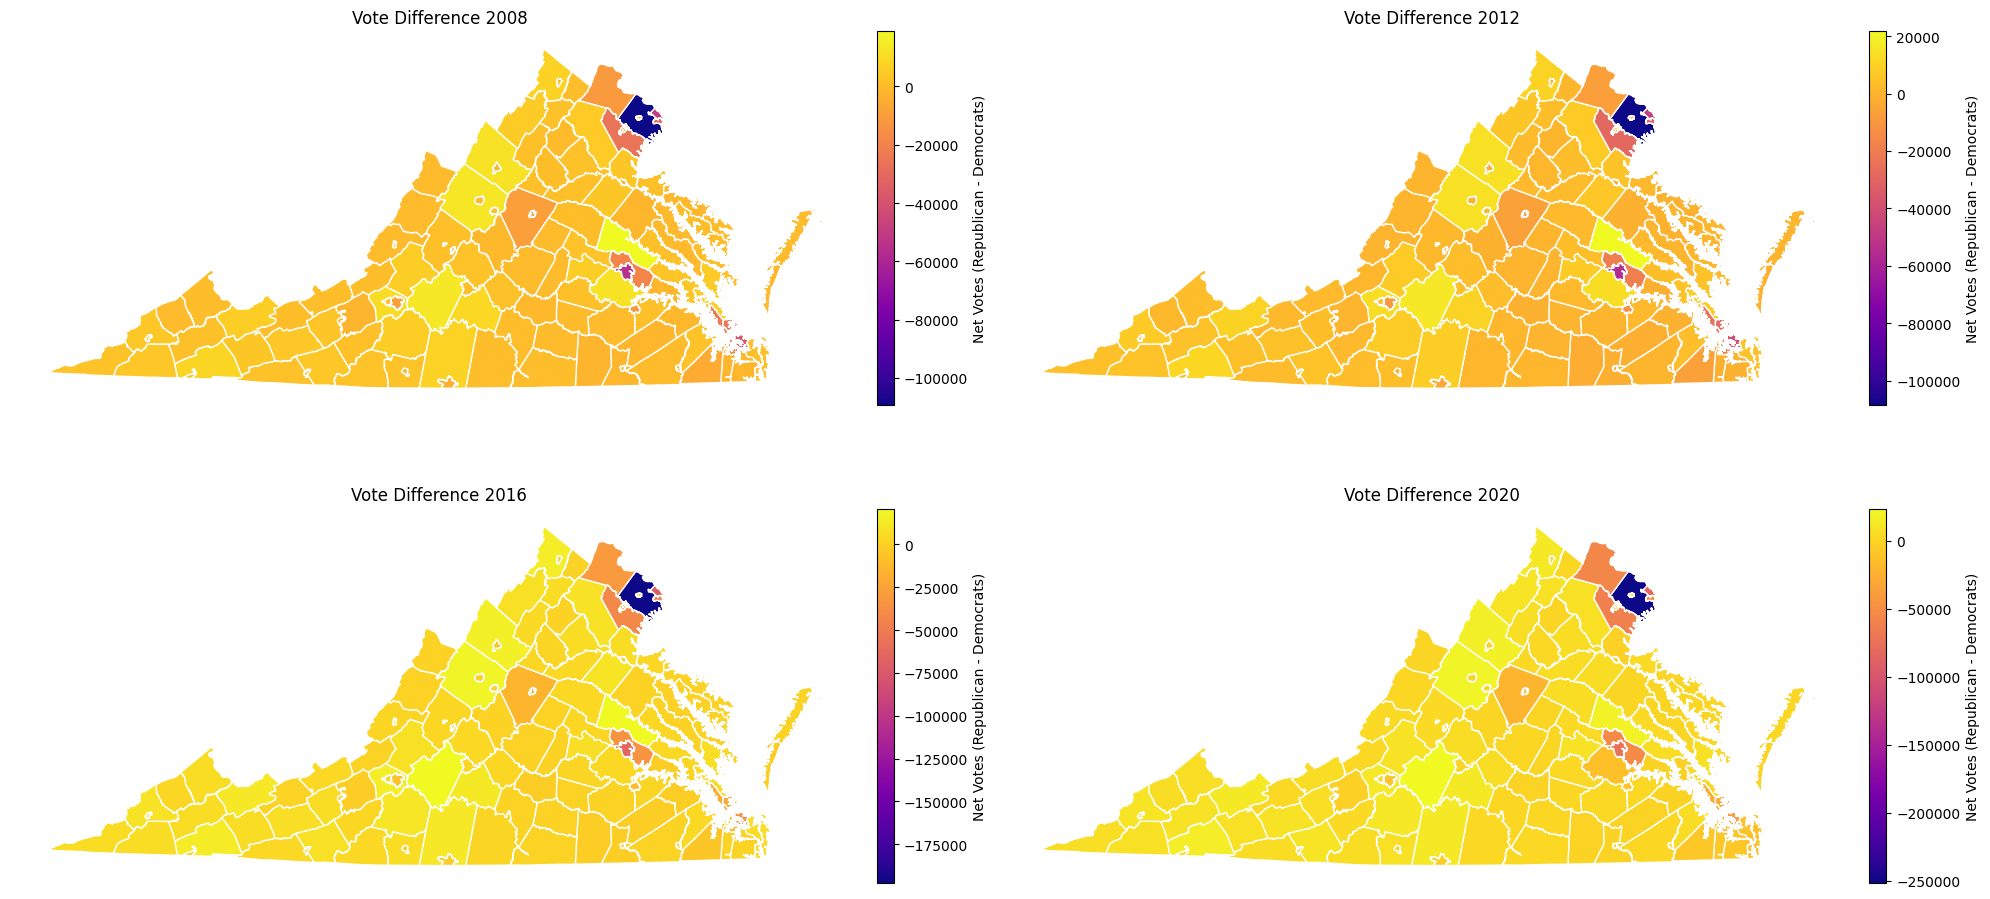

In [7]:
years = [2008, 2012, 2016, 2020]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))  # Adjust size as needed
axes = axes.flatten()

for i, year in enumerate(years):
    df_year = vdf[vdf['year'] == year]

    Dvotes = df_year.loc[df_year['party'] == 'DEMOCRAT', :].groupby('county_fips')['candidatevotes'].sum()
    Dvotes = Dvotes.rename(f'dem_votes_{year}')

    Rvotes = df_year.loc[df_year['party'] == 'REPUBLICAN', :].groupby('county_fips')['candidatevotes'].sum()
    Rvotes = Rvotes.rename(f'rep_votes_{year}')

    df_temp = dfplotting.merge(Dvotes, left_on='FIPS_left', right_on='county_fips')
    df_temp = df_temp.merge(Rvotes, left_on='FIPS_left', right_on='county_fips')

    df_temp['vote_diff'] = df_temp[f'rep_votes_{year}']-df_temp[f'dem_votes_{year}']

    ax = axes[i]
    divider = make_axes_locatable(ax)
    ax.axis('off')
    cax = divider.append_axes("right", size="2%", pad=0.08)

    df_temp.plot(ax=ax, column='vote_diff', legend=True, cax=cax, edgecolor='w', cmap='plasma')
    ax.set_title(f'Vote Difference {year}')
    cax.get_yaxis().label.set_text('Net Votes (Republican - Democrats)')

plt.tight_layout()
plt.savefig("prevyearresults.svg")

plt.show()


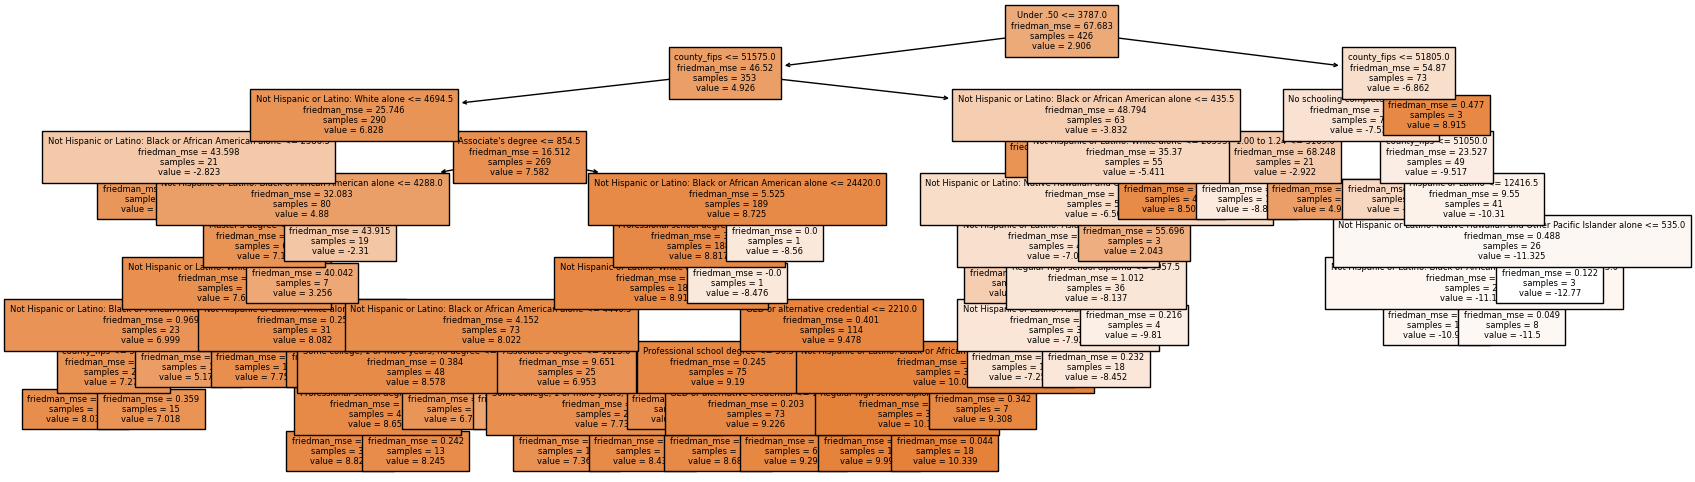

Rsq for tree depth of 10: 0.6961735977141278
RMSE for tree depth of 10: 4.786314994816976


-252281.0825682383

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression

net_count = pd.read_csv('net_votes.csv')
df = net_count.copy()

df['arcsinh Net Vote'] = np.arcsinh(df['Net Vote'])

varnames = ["Not Hispanic or Latino: White alone",
       "Not Hispanic or Latino: Black or African American alone",
       "Not Hispanic or Latino: American Indian and Alaska Native alone",
       "Not Hispanic or Latino: Asian alone",
       "Not Hispanic or Latino: Native Hawaiian and Other Pacific Islander alone",
       "Not Hispanic or Latino: Two or more races", "Hispanic or Latino",
       "No schooling completed", "Regular high school diploma",
       "GED or alternative credential", "Some college, less than 1 year",
       "Some college, 1 or more years, no degree", "Associate's degree",
       "Bachelor's degree", "Master's degree", "Professional school degree",
       "Doctorate degree", "Under .50", ".50 to .99", "1.00 to 1.24",
       "1.25 to 1.49", "1.50 to 1.84", "1.85 to 1.99", "2.00 and over","county_fips"]

y = df['arcsinh Net Vote']
X = df.loc[:,varnames]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=104)

cart = DecisionTreeRegressor(max_depth=10,criterion='friedman_mse',min_samples_split=20,random_state=1)
cart = cart.fit(X_train,y_train) # fit the regression
# visualize results
var_names = cart.feature_names_in_
plt.figure(figsize=(20,6))
plot_tree(cart, filled=True, feature_names=var_names, fontsize=6)
plt.show()

# make predictions on the test set
y_hat = cart.predict(X_test)

# residuals, rsq, rmse
e = y_test - y_hat
rsq = 1-np.sum(e**2)/np.sum((y_test - np.mean(y_train))**2)
RMSE = np.sqrt(np.mean(e**2))

print(f'Rsq for tree depth of 10: {rsq}')
print(f'RMSE for tree depth of 10: {RMSE}')

dem_2024 = pd.read_csv('demographics_2024.csv')

varnames = ["Not Hispanic or Latino: White alone",
       "Not Hispanic or Latino: Black or African American alone",
       "Not Hispanic or Latino: American Indian and Alaska Native alone",
       "Not Hispanic or Latino: Asian alone",
       "Not Hispanic or Latino: Native Hawaiian and Other Pacific Islander alone",
       "Not Hispanic or Latino: Two or more races", "Hispanic or Latino",
       "No schooling completed", "Regular high school diploma",
       "GED or alternative credential", "Some college, less than 1 year",
       "Some college, 1 or more years, no degree", "Associate's degree",
       "Bachelor's degree", "Master's degree", "Professional school degree",
       "Doctorate degree", "Under .50", ".50 to .99", "1.00 to 1.24",
       "1.25 to 1.49", "1.50 to 1.84", "1.85 to 1.99", "2.00 and over","county_fips"]

X_2024 = dem_2024.loc[:,varnames]

y_2024 = cart.predict(X_2024)
np.sum(np.sinh((y_2024))) # democrats win!

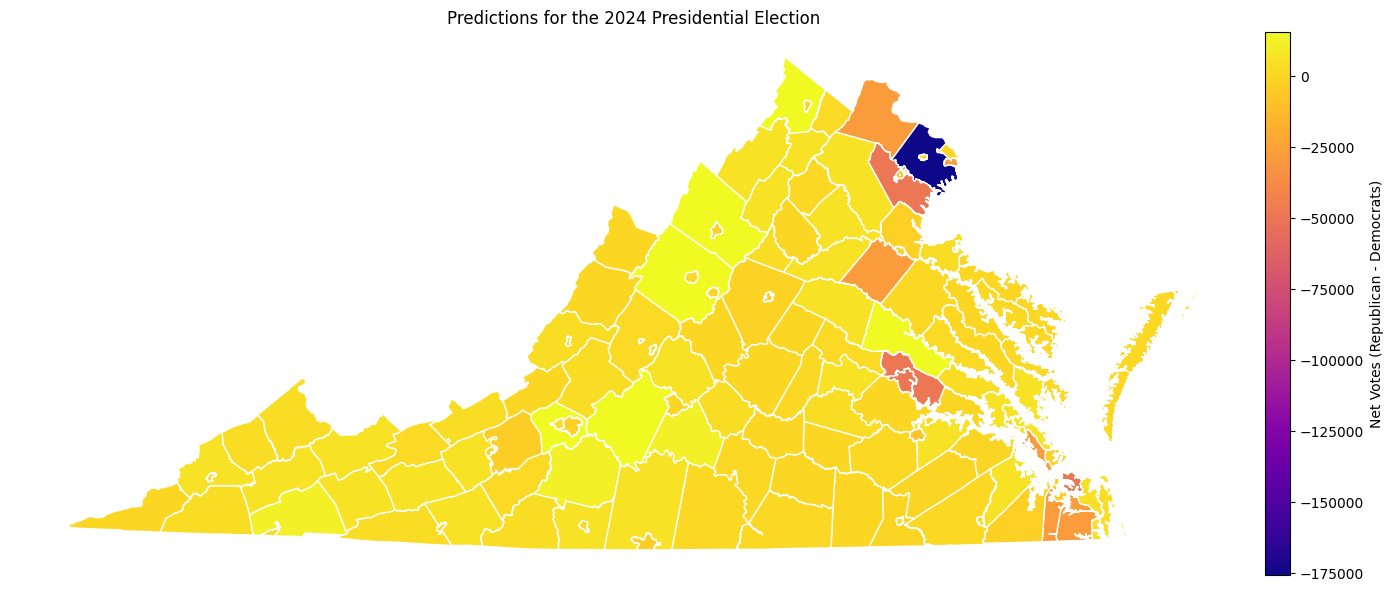

In [10]:
df_2024 = X_2024.copy()
df_2024['vote_diff'] = np.sinh(y_2024)

dfpred = dfplotting.merge(df_2024,left_on='FIPS_left',right_on='county_fips') #df1.merge(df2, left_on='lkey', right_on='rkey

fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
plt.title("Predictions for the 2024 Presidential Election")
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
dfpred.plot(ax=ax,column='vote_diff',legend=True,cax=cax,edgecolor='w',cmap='plasma')
cax.get_yaxis().label.set_text('Net Votes (Republican - Democrats)')

plt.savefig("prediction2024.svg")

plt.show()